In [1]:
import torch
from torch import nn
from transformers import AutoModelForCausalLM, AutoTokenizer
import random
import torch.nn.functional as F

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

expert1_count = torch.zeros(32, dtype = int)
expert2_count = torch.zeros(32, dtype = int)

In [3]:
class GatingMechanism(nn.Module):
    def __init__(self, input_dim, num_experts):
        super(GatingMechanism, self).__init__()
        self.gate = nn.Linear(input_dim, num_experts).to(device)

    def forward(self, x):
        x_mean = x.mean(dim=1)
        gate_scores = F.softmax(self.gate(x_mean), dim=-1)  # Shape: [batch_size, num_experts]
        return gate_scores.argmax(dim=-1)  # Shape: [batch_size]


In [4]:
import torch
import torch.nn as nn

class MoEModelWithPooling(nn.Module):
    def __init__(self, experts, input_dim):
        super().__init__()
        self.experts = nn.ModuleList(experts)
        self.num_layers = len(experts[0].base_model.model.model.layers)  # Correct path to access layers
        self.gating = nn.ModuleList([GatingMechanism(input_dim, len(experts)) for _ in range(self.num_layers)])
        self.pooling = nn.AdaptiveAvgPool1d(1).to(device)  # Example pooling layer
        self.output_layer = nn.Linear(4096, 4).to(device)
        # self.softmax = nn.Softmax(dim=1).to(device)

    def forward(self, input_ids, attention_mask, training = True):
        global expert2_count
        global expert1_count

        x = self.experts[0].base_model.model.model.embed_tokens(input_ids)

        for i in range(self.num_layers):
            expert_indices = self.gating[i](x)
            
            if training == False:
                expert2_count[i] += int(expert_indices.sum())
                expert1_count[i] += int(expert_indices.shape[0] - expert_indices.sum())
                # print(expert1_count, expert2_count)

            layer_output = torch.zeros_like(x)

            for idx, expert in enumerate(self.experts):
                mask = (expert_indices == idx).unsqueeze(-1).unsqueeze(1).half()

                expert_input = x * mask

                expert_output = expert.base_model.model.model.layers[i](expert_input, attn_mask=attention_mask)[0]
                layer_output += expert_output * mask

            x = layer_output

        x = x.transpose(1, 2)  # Adjust dimensions for pooling
        x = self.pooling(x).squeeze(2)
        x = self.output_layer(x)

        return x

# GatingMechanism definition assumed to be implemented elsewhere


In [5]:
# Load pre-trained models
from unsloth import FastLanguageModel

max_seq_length = 256 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

model1, tokenizer = FastLanguageModel.from_pretrained("unsloth_domain2",
                                                     max_seq_length=max_seq_length,
                                                     dtype=dtype,
                                                     load_in_4bit=load_in_4bit)

model2, tokenizer = FastLanguageModel.from_pretrained("ai2_arc_instruction_tuned_mistral_7b",
                                                     max_seq_length=max_seq_length,
                                                     dtype=dtype,
                                                     load_in_4bit=load_in_4bit)

Unused kwargs: ['quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


==((====))==  Unsloth: Fast Mistral patching release 2024.5
   \\   /|    GPU: Tesla V100-SXM2-32GB. Max memory: 31.739 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.2.2+cu121. CUDA = 7.0. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. Xformers = 0.0.25.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


Unsloth 2024.5 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.
Unused kwargs: ['quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


==((====))==  Unsloth: Fast Mistral patching release 2024.5
   \\   /|    GPU: Tesla V100-SXM2-32GB. Max memory: 31.739 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.2.2+cu121. CUDA = 7.0. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. Xformers = 0.0.25.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


In [19]:
model_path = 'best_model_full.pth'
model = MoEModelWithPooling([model1, model2], input_dim=4096)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

tensor([0, 0, 0, 0, 0, 0, 3, 1], device='cuda:0')
25.0
tensor([3, 1, 0, 0, 3, 0, 3, 0], device='cuda:0')
37.5
tensor([0, 0, 1, 0, 0, 2, 0, 2], device='cuda:0')
37.5
tensor([0, 1, 0, 0, 1, 0, 3, 0], device='cuda:0')
34.375
tensor([1, 0, 3, 0, 2, 0, 0, 0], device='cuda:0')
32.5
tensor([0, 1, 0, 1, 0, 0, 2, 0], device='cuda:0')
29.166666666666668
tensor([1, 1, 0, 3, 2, 0, 0, 0], device='cuda:0')
28.571428571428573
tensor([3, 0, 3, 0, 0, 0, 0, 1], device='cuda:0')
31.25
tensor([1, 1, 1, 3, 0, 1, 0, 3], device='cuda:0')
30.555555555555557
tensor([3, 0, 1, 1, 1, 3, 1, 0], device='cuda:0')
31.25
tensor([0, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
32.95454545454545
tensor([1, 0, 0, 3, 0, 3, 3, 0], device='cuda:0')
32.291666666666664
tensor([2, 0, 1, 0, 0, 3, 0, 0], device='cuda:0')
31.73076923076923
tensor([1, 3, 1, 2, 1, 0, 3, 0], device='cuda:0')
31.25
tensor([0, 0, 0, 2, 0, 0, 0, 2], device='cuda:0')
30.0
tensor([0, 0, 0, 1, 0, 2, 1, 1], device='cuda:0')
30.46875
tensor([0, 0, 0, 2, 0, 0, 0, 

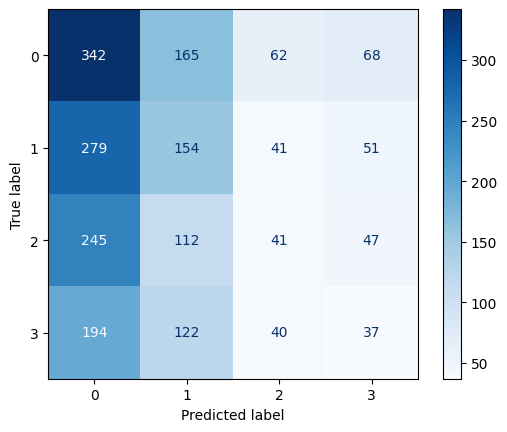

Inference Output: 28.7


In [28]:
import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def run_inference(model, val_loader):
    
    model.eval()
    total_val_loss, val_samples, total_val_correct = 0, 0, 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for i, batch in enumerate(val_loader):
            input_ids, labels, attention_mask = batch['input_ids'].to(device), batch['labels'].to(device), batch['attention_mask'].to(device)
            with torch.cuda.amp.autocast():
                output = model(input_ids, attention_mask, False).float()
                
                predictions = torch.argmax(F.softmax(output, dim=1), dim=1)
                # print(predictions)
                
                # labels = labels[shuffled_indices]
                labels_indices = torch.argmax(labels, dim=1)
                total_val_correct += (predictions == labels_indices).sum().item()

                all_predictions.extend(predictions.cpu().numpy())
                all_labels.extend(labels_indices.cpu().numpy())

            val_samples += labels.size(0)
            print(100 * total_val_correct / val_samples)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = total_val_correct / val_samples * 100
    print(f"Validation Accuracy: ", val_accuracy)

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    
    return val_accuracy

# Example usage

from datasets import load_dataset, load_from_disk, concatenate_datasets, Dataset

dataset_location = 'medmcqa-prompts'

eval_dataset = load_from_disk(f"{dataset_location}/eval_prompts_mini.hf")


from torch.utils.data import DataLoader, Dataset

class MCQDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)  # Changed to float for one-hot encoding
        return item

    def __len__(self):
        return len(self.labels)

# Function to encode the data
def encode_data(tokenizer, prompts):
    encodings = tokenizer(prompts, truncation=True, padding=True, max_length = 128)
    return encodings

prompts = [item['prompt'] for item in eval_dataset]
labels = [item['label_one_hot'] for item in eval_dataset]  # one-hot encoded labels

# Tokenize data
encodings = encode_data(tokenizer, prompts)

# Create dataset
eval_set = MCQDataset(encodings, labels)

# DataLoader
val_loader = DataLoader(eval_set, batch_size=8, shuffle=True)

output = run_inference(model, val_loader)
print("Inference Output:", output)


In [ ]:
Validation Accuracy:  29.099999999999998
Validation Accuracy:  28.7

In [ ]:
for row in output:
    t = random.random()
    if t < 0.5:
        idx = 0
    elif t < 0.8:
        idx = 1
    elif t < 0.9:
        idx = 2
    else:
        idx = 3
        
    row[idx] = 100000